# GenAI with Python: Agents from scratch

###### [Article: TowardsDataScience]()

### 0 - Setup

In [1]:
#pip install langchain --> 0.2.14
#pip install langgraph --> 0.2.19
#pip install ollama --> 0.3.1

In [2]:
import ollama

llm = "llama3.1"
q = '''who died on September 9, 2024?'''

res = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":""},
                            {"role":"user", "content":q}])
res

{'model': 'llama3.1',
 'created_at': '2024-09-15T01:03:51.041113Z',
 'message': {'role': 'assistant',
  'content': "I can't predict the future or provide information about specific individuals who may pass away. However, I can suggest some ways you could find out if someone notable died on that date. Would that help?"},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 10346416766,
 'load_duration': 42745451,
 'prompt_eval_count': 22,
 'prompt_eval_duration': 3660800000,
 'eval_count': 41,
 'eval_duration': 6637400000}

### 1 - Tools

In [4]:
from langchain_core.tools import tool
from langchain_community.tools import DuckDuckGoSearchRun

@tool("tool_browser")
def tool_browser(q:str) -> str:
    """Search on DuckDuckGo browser"""
    return DuckDuckGoSearchRun().run(q)

print( tool_browser(q) )

Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. James Earl Jones, revered actor who voiced Darth Vader in Star Wars, starred in Field of Dreams' died September 9 at his home in Dutchess County, NY. He was 93. ... September 9, 2024 1:33pm. James Earl Jones, legendary actor who was the voice of Darth Vader and Mufasa, died September 9, 2024 at his home in Dutchess County, New York at the age of 93. FILE - James Earl Jones arrives before the 84th Academy Awards on Sunday, Feb. 26, 2012, in the Hollywood section of Los Angeles. Jones, who overcame racial prejudice and a severe stutter to become a celebrated icon of stage and screen has died at age 93. His agent, Barry McPherson, confirmed Jones died Monday morning, Sept. 9, 2024, at home. Actor James Earl Jones, known for his booming voice and many memorable performances, died M

In [163]:
@tool("final_answer")
def final_answer(text:str) -> str:
    """Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.
    """
    return text

print( final_answer("yo") )

yo


In [164]:
dic_tools = {"tool_browser":tool_browser, 
             "final_answer":final_answer}

### 2 - Decision Making

In [165]:
prompt = """
You know everything, you must answer every question from the user, you can use the list of tools provided to you.
Your goal is to provide the user with the best possible answer, including key information about the sources and tools used.

Note, when using a tool, you provide the tool name and the arguments to use in JSON format. 
For each call, you MUST ONLY use one tool AND the response format must ALWAYS be in the pattern:
```json
{"name":"<tool_name>", "parameters": {"<tool_input_key>":<tool_input_value>}}
```
Remember, do NOT use any tool with the same query more than once.
Remember, if the user doesn't ask a specific question, you MUST use the `final_answer` tool directly.

Every time the user asks a question, you take note of some keywords in the memory.
Every time you find some information related to the user's question, you take note of some keywords in the memory.

You should aim to collect information from a diverse range of sources before providing the answer to the user. 
Once you have collected plenty of information to answer the user's question use the `final_answer` tool.
"""

In [166]:
str_tools = "\n".join([str(n+1)+". `"+str(v.name)+"`: "+str(v.description) for n,v in enumerate(dic_tools.values())])

prompt_tools = f"You can use the following tools:\n{str_tools}"
print(prompt_tools)

You can use the following tools:
1. `tool_browser`: Search on DuckDuckGo browser
2. `final_answer`: Returns a natural language response to the user. 
    You should provide as much context as possible and specify the source of the information.


In [167]:
# LLM deciding what tool to use
from pprint import pprint

res = ollama.chat(model=llm,
                  messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
                            {"role":"user", "content":"hello"}
                           ], format="json")

pprint(res)

{'created_at': '2024-09-16T05:32:08.589481Z',
 'done': True,
 'done_reason': 'stop',
 'eval_count': 24,
 'eval_duration': 3961527000,
 'load_duration': 9547200792,
 'message': {'content': '{"name":"final_answer", "parameters": {"text":"Hello! '
                        'I\'m happy to chat with you."}}',
             'role': 'assistant'},
 'model': 'llama3.1',
 'prompt_eval_count': 309,
 'prompt_eval_duration': 30110343000,
 'total_duration': 43664088905}


In [168]:
# LLM deciding what tool to use (output format = json)
res = ollama.chat(model=llm,
                  messages=[{"role":"system", "content":prompt+"\n"+prompt_tools},
                            {"role":"user", "content":q}
                           ], format="json")

res["message"]["content"]

'{"name":"tool_browser", "parameters": {"q":"September 9 2024 deaths"}}'

In [169]:
import json

input = json.loads(res["message"]["content"])["parameters"]["q"]
input

'September 9 2024 deaths'

In [82]:
# LLM with context
context = tool_browser(input)
print("tool output:\n", context)

output = ollama.chat(model=llm, 
                  messages=[{"role":"system", "content":"Give the most accurate answer using the folling information:\n"+context},
                            {"role":"user", "content":q}])

print("\nllm output:\n", output["message"]["content"])

tool output:
 Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. Famous deaths in September 2024. Learn about 13 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... James Earl Jones, revered actor who voiced Darth Vader in Star Wars, starred in Field of Dreams' died September 9 at his home in Dutchess County, NY. He was 93. ... Hollywood & Media Deaths In ... 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social reformer, dies at 86. 1934 Roger Fry, English artist and art critic, dies at 67. 19

### 3 - Agent

##### Data Structure

In [249]:
from pydantic import BaseModel #this is the standard class

# Taking for example the last LLM response, I want this structure:
# {tool_name: 'tool_browser', 
#  tool_input: {'q':'September 9 2024 deaths'}, 
#  tool_output: str( tool_browser({'q':'September 9 2024 deaths'})) }

class DataStructure(BaseModel):
    tool_name: str  #<--must be a string
    tool_input: dict #<--must be a dictionary
    tool_output: str | None = None #can be a string or None, default = None
    
    @classmethod
    def from_ollama(cls, res:dict): #<--return the class itself
        try:
            out = json.loads(res["message"]["content"])
            return cls(tool_name=out["name"], tool_input=out["parameters"])
        except Exception as e:
            print(f"Error from Ollama:\n{res}\n")
            raise e

# test
data = DataStructure.from_ollama(res)
print("from\n", res["message"]["content"], "\nto")
data

from
 {"name":"tool_browser", "parameters": {"q":"September 9 2024 deaths"}} 
to


DataStructure(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)

In [258]:
# test the tool output
DataStructure(tool_name="tool_browser", 
              tool_input={'q':'September 9 2024 deaths'}, 
              tool_output=str( tool_browser({'q':'September 9 2024 deaths'})) )

DataStructure(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. Famous deaths in September 2024. Learn about 13 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Overall, state media reported 21 deaths and at least 299 people injured from the weekend. A man checks his damaged boat on September 8, 2024, after Typhoon Yagi hit Ha Long Bay, in Quang Ninh ... 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economist and social 

##### Memory System

In [173]:
'''
Messages in Memory will have this structure:
[{'role':'assistant', 'content':'{"name":"final_answer", "parameters":{"text":"How can I assist you today?"}}'},
 {'role':'user', 'content':None}]
'''

def save_memory(lst_data:list[DataStructure], user_q:str) -> list:
    ## create
    memory = []
    for data in [data for data in lst_data if data.tool_output is not None]:
        memory.extend([
            ### assistant message
            {"role": "assistant", "content": json.dumps({"name":data.tool_name, "parameters":data.tool_input})},
            ### user message
            {"role":"user", "content":data.tool_output}
        ])
    
    ## add a reminder of the original goal
    if memory:
        memory += [{"role":"user", "content":(f'''
                This is just a reminder that my original query was `{user_q}`.
                Only answer to the original query, and nothing else, but use the information I gave you. 
                Provide as much information as possible when you use the `final_answer` tool.
                ''')}]
    return memory

create_memory(lst_data=[data], user_q=q)

[]

In [174]:
chat_history = [{"role": "user", "content": "hi there, how are you?"},
                {"role": "assistant", "content": "I'm good, thanks!"},
                {"role": "user", "content": "I have a question"},
                {"role": "assistant", "content": "tell me"}]

##### Create Agent

In [198]:
def create_agent(user_q:str, chat_history:list[dict], lst_data:list[DataStructure], lst_tools:list) -> DataStructure:
    ## start memory
    memory = save_memory(lst_data=lst_data, user_q=user_q)
    
    ## track used tools
    if memory:
        tools_used = [data.tool_name for data in lst_data]
        if len(tools_used) >= len(lst_tools):
            memory[-1]["content"] = "You must now use the `final_answer` tool."
        
    ## messages
    messages = [{"role":"system", "content":prompt+"\n"+prompt_tools},
                *chat_history,
                {"role":"user", "content":user_q},
                *memory]
    pprint(messages)
    
    ## output
    res = ollama.chat(model=llm, messages=messages, format="json")
    return DataStructure.from_ollama(res)

# test
agent = create_agent(user_q=q, chat_history=chat_history, lst_data=[], lst_tools=dic_tools.keys())
print("\nAgent:", agent)

[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directly.\n'
             

### 4 - Graph Workflow

##### State

In [277]:
import typing

class State(typing.TypedDict):
    input: str
    chat_history: list
    lst_data: list
    output: dict

# test
state = State({"input":q, "chat_history":chat_history, "lst_data":[data], "output":{}})
state

{'input': 'who died on September 9, 2024?',
 'chat_history': [{'role': 'user', 'content': 'hi there, how are you?'},
  {'role': 'assistant', 'content': "I'm good, thanks!"},
  {'role': 'user', 'content': 'I have a question'},
  {'role': 'assistant', 'content': 'tell me'}],
 'lst_data': [DataStructure(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output=None)],
 'output': {}}

##### Nodes

In [242]:
# Agent
def node_agent(state):
    print("--- node_agent ---")
    return {"Agent":[
        create_agent(user_q=state["input"], 
                     chat_history=state["chat_history"], 
                     lst_data=state["lst_data"], 
                     lst_tools=dic_tools.keys())
            ]}

# test
node_agent(state)

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

{'Agent': [DataStructure(tool_name='tool_browser', tool_input={'q': 'September 9 2024 death'}, tool_output=None)]}

In [262]:
# Tools
def node_tool(state):
    print("--- node_tool ---")
    data = state["lst_data"][-1]
    print(f"run_tool --> {data.tool_name}(input={data.tool_input})")
    
    output = DataStructure(tool_name=data.tool_name, 
                           tool_input=data.tool_input, 
                           tool_output=str(dic_tools[data.tool_name](data.tool_input)) )
    
    return {"output":output} if data.tool_name == "final_answer" else {"lst_data":[output]}

# test
node_tool(state)

--- node_tool ---
run_tool --> tool_browser(input={'q': 'September 9 2024 deaths'})


{'lst_data': [DataStructure(tool_name='tool_browser', tool_input={'q': 'September 9 2024 deaths'}, tool_output='Search in the United States of people who died on September 9, 2024 obituaries and condolences. Find an obituary, get service details, leave condolence messages or send flowers or gifts in memory of a loved one. Famous deaths in September 2024. Learn about 13 historical figures, notable people and celebrities who died in Sep 2024 like James Earl Jones and Alberto Fujimori. Menu. ... James Earl Jones (1931-2024) Sep 9 American Tony, Emmy, Grammy, and Golden Globe winning actor (The Great White Hope; Star Wars - "voice of Darth Vader"; Field Of Dreams"), ... Overall, state media reported 21 deaths and at least 299 people injured from the weekend. A man checks his damaged boat on September 8, 2024, after Typhoon Yagi hit Ha Long Bay, in Quang Ninh ... 1926 William S. Scarborough, American linguist and author (Birds of Aristophanes), dies at 74. 1931 Lujo Brentano, German economi

##### Edges

In [263]:
def edges(state):
    print("--- edges ---")
    return state["lst_data"][-1].tool_name if isinstance(state["lst_data"], list) else "final_answer"

edges(state)

--- edges ---


'tool_browser'

##### Graph

In [265]:
from langgraph.graph import StateGraph, END

## start the graph
workflow = StateGraph(State)

## add Agent node
workflow.add_node(node="Agent", action=node_agent) 
workflow.set_entry_point(key="Agent")  #<--user query

## add Tools nodes
for k in dic_tools.keys():
    workflow.add_node(node=k, action=node_tool)

## edges from Agent
workflow.add_conditional_edges(source="Agent", path=edges)

## edges to Agent
for k in dic_tools.keys():
    if k != "final_answer":
        workflow.add_edge(start_key=k, end_key="Agent")

## end the graph
workflow.add_edge(start_key="final_answer", end_key=END)
g = workflow.compile()

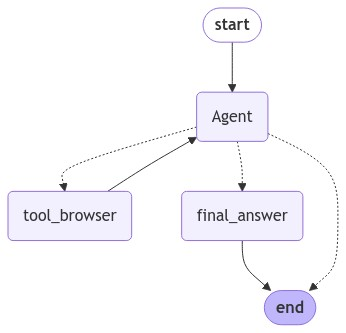

In [266]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(
    g.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)
))

##### Run

In [280]:
out = g.invoke(input={'input':q,
                      'chat_history':chat_history, 
                      'lst_data':[], 
                      'output':{}
                     })

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

InvalidUpdateError: Must write to at least one of ['input', 'chat_history', 'lst_data', 'output']

In [279]:
## Give the first input state
steps = g.stream(input={'input':q,
                        'chat_history':chat_history, 
                        'lst_data':[], 
                        'output':{}
                       }) 
for step in steps:
    print(step)
    print("----")

--- node_agent ---
[{'content': '\n'
             'You know everything, you must answer every question from the '
             'user, you can use the list of tools provided to you.\n'
             'Your goal is to provide the user with the best possible answer, '
             'including key information about the sources and tools used.\n'
             '\n'
             'Note, when using a tool, you provide the tool name and the '
             'arguments to use in JSON format. \n'
             'For each call, you MUST ONLY use one tool AND the response '
             'format must ALWAYS be in the pattern:\n'
             '```json\n'
             '{"name":"<tool_name>", "parameters": '
             '{"<tool_input_key>":<tool_input_value>}}\n'
             '```\n'
             'Remember, do NOT use any tool with the same query more than '
             'once.\n'
             "Remember, if the user doesn't ask a specific question, you MUST "
             'use the `final_answer` tool directl

InvalidUpdateError: Must write to at least one of ['input', 'chat_history', 'lst_data', 'output']